In [1]:
import sys
nb_path = '/content/my-bucket'
sys.path.insert(0, nb_path)
# Do this just once
!pip install --target=$nb_path jdc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import os
import wandb
import torch
import pickle
import numpy as np
%matplotlib inline
import pandas as pd
import gradio as gr
import seaborn as sns
import tensorflow as tf
from typing import Dict
from ast import literal_eval
from torch.optim import AdamW
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
#from kaggle_secrets import UserSecretsClient
from torch.nn import BCEWithLogitsLoss, BCELoss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from transformers import XLNetForSequenceClassification, XLNetTokenizer,BertForSequenceClassification,BertTokenizer, RobertaForSequenceClassification,RobertaTokenizer

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
dataset='/content/sample_data/PubMed Multi Label Text Classification Dataset Processed.csv'

df= pd.read_csv(dataset)
df.head(4)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,1,0,0,1,0,0,0,0,0,0
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,1,1,1,0,1,1,0,1,1,1
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,1,0,1,0,0,0,1,0,0,0
3,Multilayer capsules: a promising microencapsul...,"In 1980, Lim and Sun introduced a microcapsule...","['Acrylic Resins', 'Alginates', 'Animals', 'Bi...",11426874,"[['D05.750.716.822.111', 'D25.720.716.822.111'...","['Chemicals and Drugs [D]', 'Technology, Indus...",1,1,1,1,1,0,1,0,0,1,0,0,0,0


In [11]:
cols = df.columns
cols = list(df.columns)
mesh_Heading_categories = cols[6:]
num_labels = len(mesh_Heading_categories)
print('Mesh Labels Root Class: "\n"',mesh_Heading_categories)
print("\n")
print('Number of Labels: ' ,num_labels)

Mesh Labels Root Class: "
" ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']


Number of Labels:  14


In [12]:
counts = []
for mesh_Heading_category in mesh_Heading_categories:
    counts.append((mesh_Heading_category, df[mesh_Heading_category].sum()))
df_count = pd.DataFrame(counts, columns=['Root Label', 'number of Abstract'])
df_count

,Root Label,number of Abstract
0,A,23263
1,B,46577
2,C,26453
3,D,31074
4,E,39202
5,F,8885
6,G,33609
7,H,6069
8,I,5595
9,J,5531


<BarContainer object of 14 artists>


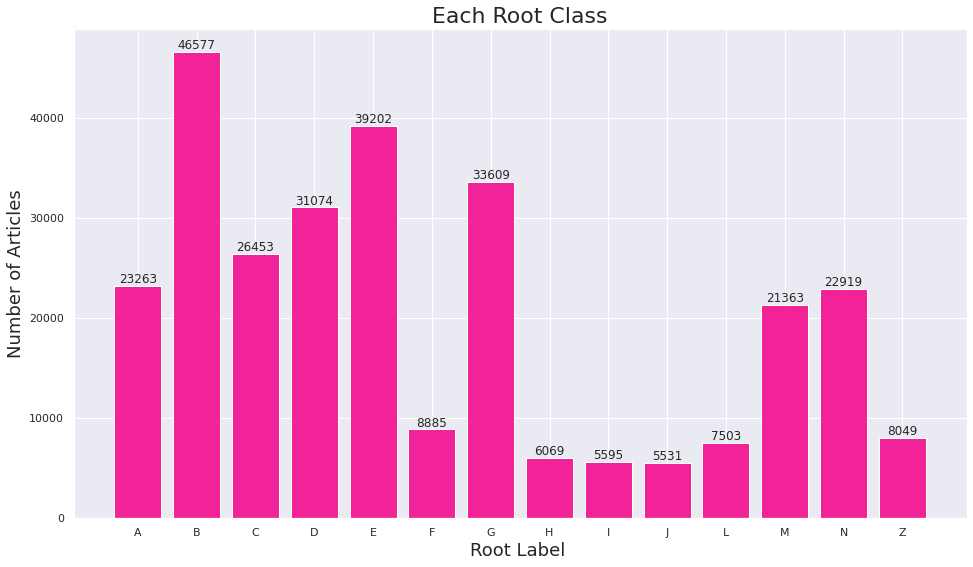

CPU times: user 438 ms, sys: 11.1 ms, total: 449 ms
Wall time: 1.07 s


In [20]:
%%time
sns.set(font_scale = 1)
plt.figure(figsize=(16,9))

#ax= sns.barplot(mesh_Heading_categories, df.iloc[:,6:].sum().values)

ax = plt.bar(mesh_Heading_categories,  df.iloc[:,6:].sum().values, color='#f22299')
print(ax)

plt.title("Each Root Class", fontsize=22)
plt.ylabel('Number of Articles', fontsize=18)
plt.xlabel('Root Label ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = df.iloc[:,6:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)
        
    
plt.show()



In [21]:
df_train, df_test = train_test_split(df, random_state=32, test_size=0.20, shuffle=True)
print(df_train.shape)
print(df_test.shape)
df_train['one_hot_labels'] = list(df_train[mesh_Heading_categories].values)
df_train.head(3)

(40000, 20)
(10000, 20)


,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
31112,Neurofibromatosis associated with a coronary a...,A case of a patient with type 1 neurofibromato...,"['Aged', 'Coronary Aneurysm', 'Humans', 'Male'...",11144803,"[['M01.060.116.100'], ['C14.280.647.250.250', ...","['Named Groups [M]', 'Diseases [C]', 'Organism...",0,1,1,0,...,0,0,0,0,0,0,1,0,0,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
48911,Phenolic constituents from Perovskia atriplici...,"Perovskoate, an isorinic acid derivative (1) a...","['Caffeic Acids', 'Catechols', 'Cholinesterase...",16644529,"[['D02.241.223.200.054'], ['D02.455.426.559.38...","['Chemicals and Drugs [D]', 'Analytical, Diagn...",0,1,0,1,...,0,1,0,0,0,0,0,0,0,"[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
16394,Motion artifact and background noise suppressi...,Optical coherence tomography (OCT) is a techni...,"['Algorithms', 'Angiography', 'Artifacts', 'Ar...",25089975,"[['G17.035', 'L01.224.050'], ['E01.370.350.700...","['Phenomena and Processes [G]', 'Information S...",0,0,0,0,...,0,1,0,0,0,1,0,1,0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]"


In [22]:
labels = list(df_train.one_hot_labels.values)
Article_train = list(df_train.abstractText.values)
print(labels[0])
print(Article_train[0])

[0 1 1 0 1 0 0 0 0 0 0 1 0 0]
A case of a patient with type 1 neurofibromatosis associated with popliteal and coronary artery aneurysms is described in which cross-sectional imaging provided diagnostic information.


In [25]:
max_length = 128


## preTrained preprocessing with Bert
tokenizer_Bert = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True) 


encodings_Bert = tokenizer_Bert.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) 
print('tokenizer outputs: ', encodings_Bert.keys())


input_ids_Bert= encodings_Bert['input_ids'] # tokenized and encoded sentences
attention_masks_Bert = encodings_Bert['attention_mask'] # attention masks

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [26]:
%%time
## preTrained preprocessing with Roberta

tokenizer_Roberta = RobertaTokenizer.from_pretrained('distilroberta-base', do_lower_case=False)  # tokenizer

#tokenizer's encoding method
encodings_Roberta = tokenizer_Roberta.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) 
print('tokenizer outputs: ', encodings_Roberta.keys())

input_ids_Roberta= encodings_Roberta['input_ids'] # tokenized and encoded sentences
attention_masks_Roberta = encodings_Roberta['attention_mask'] # attention masks

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])
CPU times: user 1min 9s, sys: 357 ms, total: 1min 9s
Wall time: 1min 20s


In [27]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow me to stratify split our training data later

label_counts = df_train.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [49950, 49878, 49876, 49838, 49759, 49739, 49696, 49590, 49585, 49574, 49546, 49535, 49528, 49487, 49470, 49419, 49404, 49395, 49314, 49245, 49150, 49080, 49071, 49058, 49004, 48991, 48982, 48922, 48919, 48757, 48708, 48686, 48679, 48677, 48602, 48594, 48583, 48531, 48454, 48438, 48411, 48388, 48375, 48350, 48337, 48298, 48213, 48185, 48123, 48085, 48075, 48056, 48020, 48001, 47876, 47840, 47828, 47817, 47776, 47671, 47495, 47435, 47369, 47363, 47362, 47359, 47356, 47321, 47293, 47244, 47239, 47159, 47104, 47089, 47061, 47050, 47002, 46955, 46887, 46874, 46837, 46747, 46706, 46651, 46635, 46598, 46446, 46365, 46247, 46223, 46199, 46170, 46033, 46028, 45955, 45946, 45756, 45755, 45712, 45682, 45671, 45573, 45509, 45430, 45391, 45317, 45294, 45226, 45216, 45190, 45134, 45132, 45105, 45052, 45035, 45025, 44971, 44953, 44867, 44851, 44827, 44777, 44763, 44625, 44606, 44598, 44586, 44579, 44574, 44568, 44499, 44479, 44462, 44296, 44206, 44181, 44116

In [28]:
#Bert or Roberta
attention_masks = attention_masks_Bert #attention_masks_Roberta
input_ids = input_ids_Bert # input_ids_Roberta

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [31]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
batch_size = 64

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [32]:
%%time
#Tried Several Models Locally XLNet was performing Best. Note If you are changing the model then change the Tokenizer also

# model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=num_labels)

model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=num_labels)

model.cuda()
print('Model Pushed to Cuda for Training')

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

Model Pushed to Cuda for Training
CPU times: user 8.61 s, sys: 2.23 s, total: 10.8 s
Wall time: 17.8 s


In [33]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [34]:
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)

In [36]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [46]:
%%time

# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (Orignal author's recommend between 10 and 20)
epochs = 12

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass for multilabel classification
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
        # Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
        # Also This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable 
        # than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the 
        # log-sum-exp trick for numerical stability.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)  
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

Epoch :   0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.4150684625506401


Epoch :   0%|          | 0/12 [12:44<?, ?it/s]

F1 Validation Accuracy:  84.0499306518724
Flat Validation Accuracy:  9.375




Error: ignored

In [47]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

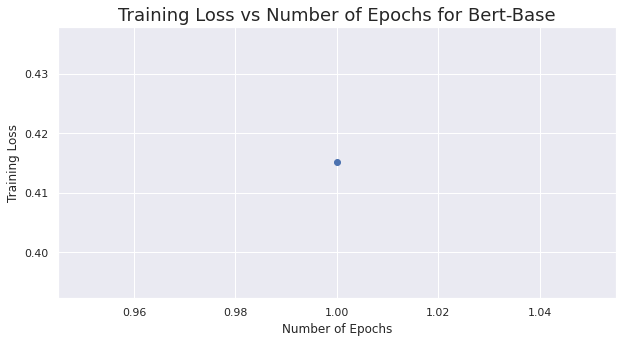

In [48]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

(0.0, 100.0)

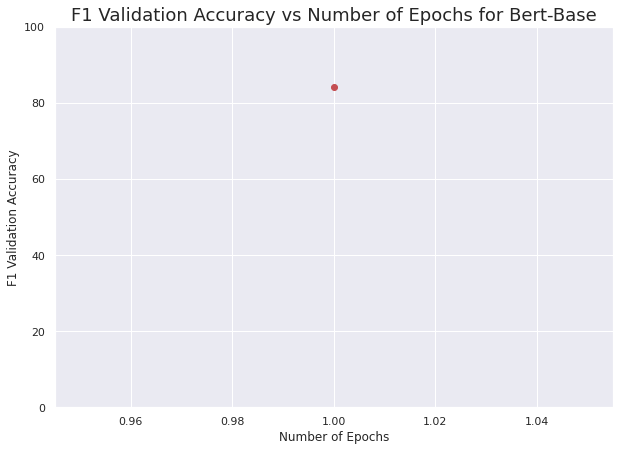

In [49]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

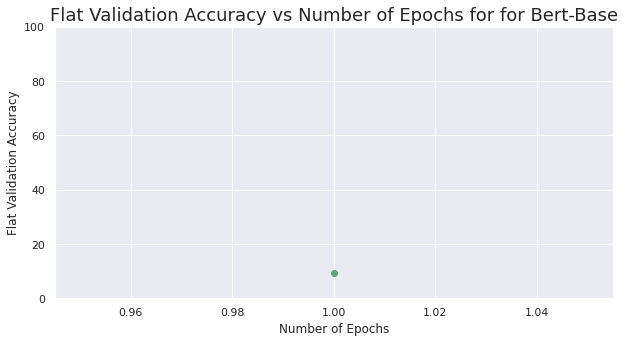

In [50]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

In [51]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
35083,Expression of N-methyl-d-aspartate receptor 1 ...,High levels of glutamate can be toxic to retin...,"['Analysis of Variance', 'Animals', 'Cell Deat...",17942238,"[['E05.318.740.150', 'N05.715.360.750.125', 'N...","['Analytical, Diagnostic and Therapeutic Techn...",1,1,1,1,...,0,1,0,0,0,0,0,1,0,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
9005,Protection of pregnant swine by vaccination ag...,The protection conferred on pregnant gilts by ...,"['Animals', 'Antibodies, Bacterial', 'Bacteria...",7150130,"[['B01.050'], ['D12.776.124.486.485.114.107', ...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",0,1,1,1,...,0,1,0,0,0,0,0,1,0,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
23836,An examination of Escherichia coli strains iso...,Ninety-five strains of Escherichia coli isolat...,"['Animals', 'Antigens', 'Antigens, Bacterial',...",6135266,"[['B01.050'], ['D23.050'], ['D23.050.161'], ['...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",1,1,1,1,...,0,1,0,0,0,0,0,0,0,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [52]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.abstractText.values)
test_mesh_categories = list(df_test.columns[6:20])

In [53]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [54]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

In [55]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 1min 20s, sys: 69 ms, total: 1min 20s
Wall time: 1min 20s


In [56]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='micro')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )
print('Test Flat Accuracy: ',Test_Flat_Accuracy,'\n')

df_test=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()

Test F1 Accuracy:  0.8288694422345974
Test Flat Accuracy:  0.1222 

              precision    recall  f1-score   support

           A       0.73      0.82      0.77      4609
           B       0.94      1.00      0.97      9250
           C       0.83      0.87      0.85      5206
           D       0.91      0.90      0.91      6259
           E       0.78      1.00      0.88      7778
           F       0.82      0.61      0.70      1767
           G       0.82      0.89      0.85      6799
           H       0.49      0.01      0.03      1221
           I       0.67      0.45      0.54      1068
           J       0.69      0.19      0.29      1110
           L       0.81      0.13      0.23      1491
           M       0.84      0.89      0.86      4232
           N       0.84      0.71      0.77      4602
           Z       0.75      0.56      0.64      1558

   micro avg       0.83      0.82      0.83     56950
   macro avg       0.78      0.65      0.66     56950
weighted avg

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
df_report.to_csv('Classification_Report.csv',index=True)